# Programming Exercise 2: Logistic Regression with regularization

Regularized Logistic regression is a classification algorithm 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
 

Number of samples 118
Number of parameters:  2
y shape (118,)


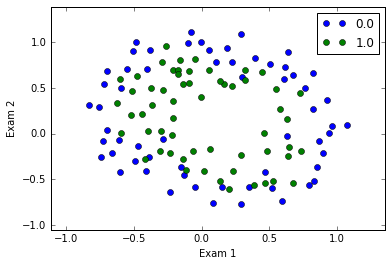

In [2]:
data = np.loadtxt('ex2data2.txt', delimiter=',')

X = data[:,0:2]
y = data[:,2]  # differs from y = data[:, 2:3]
m,n = X.shape
print('Number of samples', m)
print('Number of parameters: ', n)
print('y shape', y.shape)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
groups = df.groupby(y)
plt.margins(0.15)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)

plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend()
plt.show()


## try solution directly from scikit learn

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

#lr = LogisticRegression() # default solver to 'liblinear"

# lbfgs seems to be Same as mine
lr = LogisticRegression(solver='lbfgs', C=0.99)  # C = 1/lambda (default = 1, if lower, regularization is stronger)
# lr = LogisticRegression(solver='sag', max_iter = 1000000000)  # ???
#lr = LogisticRegression(solver='newton-cg', max_iter = 1000000000)  # seems quite the same as lbfgs

lr.fit(X_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(X_train,y_train))
print('Score on test set : ', lr.score(X_test,y_test))


X_small_test = [
    [0,0],
    [-0.25,0.25],
    [0.2,0.5],
    [1,-1],
    [1,1],
    [-0.25, 1.5],  # expected as human : 1 1 1 0 0 0  
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_small_test))


Coeff = [[-0.28135718  0.03654246]], intercept = [ 0.01196357]
Score on training set :  0.526785714286
Score on test set :  0.666666666667
Predict on small test :  [ 1.  1.  0.  0.  0.  1.  1.  0.]


Explanation for the equation :
$z=w_{0} + w_{1}x_{1} + w_{2}x_{2}$

Here, $x{_2}$ is on y axis, so we can define the equation as follows:
$x_{2} = \frac{w_{0}}{w_{2}} - \frac{w_{1}}{w_{2}}x_{1}$


Predict on small test :  [ 1.  1.  1.  0.  0.  1.  0.]
[ 0.01196357 -0.28135718  0.03654246]


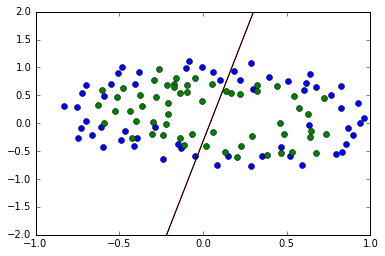

In [126]:
def plotDecisionBoundary(theta, X):
    # draw the line according to theta parameters
    plot_x = [min(X[:,1])-1, max(X[:,1]+1)]
    #print('plot_x:',plot_x)

    plot_y = (-1/theta[2]) * (np.multiply(theta[1],plot_x) + theta[0])
    #print('plot_y:',plot_y)

    plt.plot(plot_x, plot_y)

    #plt.show()
    
def plotDecisionBoundary2(lr):
    w = lr.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1, 1)
    yy = a * xx - (lr.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k-')
    
X_check = [
    [0,0],
    [-1,1],
    [-1,-1],
    [1,1],
    [1,-1],
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_check))

test = np.append(lr.intercept_, lr.coef_)
print(test)
plt.xlim(-1,1)
plt.ylim(-2,2)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
    

plotDecisionBoundary(test, X_train)
plotDecisionBoundary2(lr)
plt.show()

To have a non-linear boundary, we need polynomials. For instance, 6 power :
x1, x2, x1x2, x1^2*x2, x2^2*x1, x1^3 etc 

In [127]:
# Take a 2 parameters (3 with the ones) and return a n parameters according to polynomials parameters 
def generatePolynomials(order, X):
    #print('X:', X)
    XP = np.array([]).reshape(len(X), 0) #np.empty((len(X),1), dtype=float)
    print('XP :  ', XP)
    for i in range(order+1):
        for j in range(i+1):
            #print('x1^{} * x2^{}'.format(j, i-j))
            temp = np.power(X[:,0:1], j)
            temp = np.power(X[:,1:2], i-j)
            XP = np.hstack((XP, np.power(X[:,0:1], j) * np.power(X[:,1:2], i-j)))
    return XP

In [128]:
XP_train = generatePolynomials(6, X_train)
XP_test = generatePolynomials(6, X_test)

#print(XP_train)
print(XP_train.shape)

lr.fit(XP_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(XP_train,y_train))
print('Score on test set : ', lr.score(XP_test,y_test))

def plotDescisionBoundaryPoly(lr):
    
    h = .02
    x_min, x_max = XP_train[:, 0].min() - 1, XP_train[:, 0].max() + 1
    y_min, y_max = XP_train[:, 1].min() - 1, XP_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

    

XP :   []
XP :   []
(112, 28)
Coeff = [[  2.77412070e-05   1.14054704e+00   5.60750740e-01  -1.45677644e+00
   -9.29428696e-01  -1.86758636e+00  -1.86231625e-01  -3.38532688e-01
   -2.76599669e-01   6.07956571e-02  -1.18374856e+00  -2.61686236e-01
   -5.51774121e-01  -6.77511145e-02  -1.41244075e+00  -4.44182126e-01
   -2.72941964e-01  -2.22796913e-01  -5.05828524e-02  -1.83521077e-01
   -2.65137918e-01  -8.99314672e-01  -1.19866170e-01  -2.83872444e-01
    9.71145004e-03  -2.75400080e-01   2.74065247e-02  -1.03545451e+00]], intercept = [ 1.25048079]
Score on training set :  0.839285714286
Score on test set :  0.833333333333
